**functions**

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import cvxpy as cp
from fancyimpute import MatrixFactorization
from fancyimpute import SoftImpute
import pandas as pd
from numpy.linalg import svd

In [40]:
def generate_low_rank_matrix(m, n, r, loc,sigma, seed=None):   

    assert r <= min(m, n)
    if seed is not None:
        np.random.seed(seed)

    A = np.random.normal(loc=loc, scale=sigma, size=(m,r)) 
    B = np.random.normal(loc=loc, scale=sigma, size=(r,n))
    M = A @ B  

    return M

In [41]:
def mask_matrix_with_noise(A, keep_ratio=0.2, sigma=0.1, seed=None):   #掩码＋噪音函数
  
    assert 0 < keep_ratio <= 1, "keep_ratio 必须在 (0, 1] 之间"
    if seed is not None:
        np.random.seed(seed)

    m, n = A.shape
    total = m * n
    num_keep = int(keep_ratio * total)


    indices = np.random.permutation(total)
    keep_indices = indices[:num_keep]

    
    mask = np.zeros(total, dtype=bool)
    mask[keep_indices] = True
    mask = mask.reshape(m, n)

    
    A_masked = A.copy()
    noise = np.random.normal(loc=0.0, scale=sigma, size=A.shape)
    A_masked[mask] += noise[mask]      
    A_masked[~mask] = np.nan          

    return A_masked, mask.astype(int)

In [42]:
def split_matrix_exactly(A, k):

    m, n = A.shape

   
    if not isinstance(k, int) or k <= 0:
        raise ValueError("k (子矩阵数量) 必须是一个正整数。")
    rows_per_block = m // k 
    indices = np.arange(k + 1) * rows_per_block
    blocks = [A[indices[i]:indices[i+1], :] for i in range(k)]

    return blocks

In [43]:
def compute_error(M_true, X_recovered, eps=1e-8, mode="Fro"):
    if mode=="Fro":
       return np.linalg.norm(X_recovered - M_true, 'fro')
    if mode=="rel":
       return np.linalg.norm(X_recovered - M_true, 'fro')/(np.linalg.norm(M_true, 'fro') + eps)
    if mode=="inf":
       return np.max(np.abs(X_recovered - M_true))

In [44]:
def truncated_svd(M, r=None, tol=1e-10):
    U, S, Vt = np.linalg.svd(M, full_matrices=False)

    if r is None:
        r = np.sum(S > tol)  
    
    U_r = U[:, :r]
    S_r = S[:r]
    Vt_r = Vt[:r, :]
    return U_r, S_r, Vt_r    

In [45]:
def distributed_eigenspace_estimation(V_list, V_ref=None):
    
    shapes = [V.shape for V in V_list]
    if len(set(shapes)) != 1:
        print("输入矩阵形状不同")
        return None

    m = len(V_list)
    n, r = shapes[0]

    # 设定参考解   这里好像也可以用ensemble的方法
    if V_ref is None:
        V_ref = V_list[0]
    else:
        if V_ref.shape != (n, r):
            print("参考矩阵形状与输入矩阵不一致")
            return None

    
    V_aligned_list = []
    for V_local in V_list:
        M = V_local.T @ V_ref
        U, _, Vt = np.linalg.svd(M,full_matrices=False)
        Z = U @ Vt
        V_aligned = V_local @ Z
        V_aligned_list.append(V_aligned)

    
    V_bar = sum(V_aligned_list) / m

    V_left, R_right = np.linalg.qr(V_bar,'reduced')

    return V_left

In [46]:
def solve_L_with_missing(Y, Vt, lambda_reg=1e-4):
    m, n = Y.shape
    r, n_check = Vt.shape
    assert n == n_check

    L = np.zeros((m, r))
    for i in range(m):
        row = Y[i, :]
        mask = ~np.isnan(row)
        if not np.any(mask):
            continue

        y_obs = row[mask]
        Vt_obs = Vt[:, mask].T

        # Ridge-like regularization
        A = Vt_obs.T @ Vt_obs + lambda_reg * np.eye(r)
        b = Vt_obs.T @ y_obs
        L[i, :] = np.linalg.solve(A, b)

    return L

In [47]:
def debiased_MC(M, p, model="softimpute", rank=None):
    if model == "softimpute":
        Z=SoftImpute(shrinkage_value=0.1, max_iters=100, max_rank=rank, verbose=False).fit_transform(M)
        mask = ~np.isnan(M)
        Z_minus_M = np.zeros_like(Z)
        Z_minus_M[mask] = Z[mask] - M[mask]

        
        Z0 = Z - (1 / p) * Z_minus_M 
        U, S, Vt = svd(Z0, full_matrices=False)
        U_r = U[:, :rank]
        S_r = S[:rank]
        Vt_r = Vt[:rank, :]
        Md = U_r @ np.diag(S_r) @ Vt_r
        return Md


    if model == "sdp":
        m, n = M.shape
        Omega = ~np.isnan(M)
        observed = np.nan_to_num(M, nan=0.0)
        X = cp.Variable((m, n), name="X_completed")
        frobenius_loss = cp.sum_squares(cp.multiply(Omega, X - observed))
        lambda_reg = 1.0
        objective = cp.Minimize(0.5 * frobenius_loss + lambda_reg * cp.norm(X, "nuc"))
        problem = cp.Problem(objective)
        problem.solve(solver=cp.SCS, verbose=False)
        if problem.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
             Z = X.value

        mask = ~np.isnan(M)
        Z_minus_M = np.zeros_like(Z)
        Z_minus_M[mask] = Z[mask] - M[mask]

        
        Z0 = Z - (1 / p) * Z_minus_M 
        U, S, Vt = svd(Z0, full_matrices=False)
        U_r = U[:, :rank]
        S_r = S[:rank]
        Vt_r = Vt[:rank, :]
        Md = U_r @ np.diag(S_r) @ Vt_r
        return Md

In [48]:
def denoise_method(Z0,rank):
    U, S, Vt = svd(Z0, full_matrices=False)
    U_r = U[:, :rank]
    S_r = S[:rank]
    Vt_r = Vt[:rank, :]
    Md = U_r @ np.diag(S_r) @ Vt_r
    return Md

**main experiment**

**softimpute  U(500,2) and V(100,2), $M=UV^t$  and $U_{ij} \sim N (1,0.1)$ ,$V_{ij} \sim N (1,0.1)$,$E_{ij} \sim N (0,0.01)$**

,% observed,baseline,before align,align
0,0.01,421.83,1073.01,1824.06
1,0.02,300.35,924.05,917.10
2,0.03,236.75,715.89,534.29
3,0.04,175.91,574.02,340.13
4,0.05,135.88,495.63,235.24
5,0.06,103.92,387.86,150.19
6,0.07,83.94,318.64,111.40
7,0.08,64.77,261.62,86.24
8,0.09,57.05,224.18,64.79
9,0.10,51.87,193.16,56.07


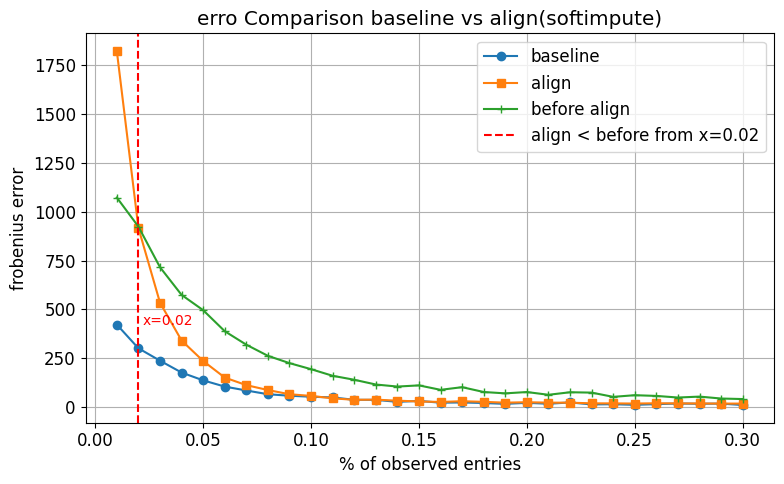

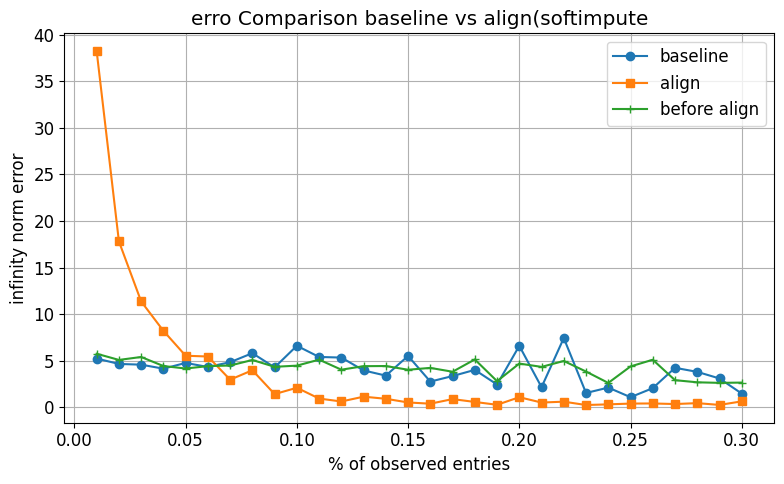

In [31]:
M_true=generate_low_rank_matrix(500,100,2,1,0.1,seed=42)
noise = np.random.normal(loc=0.0, scale=np.sqrt(0.01), size=M_true.shape)
M = M_true + noise
blocks_true=split_matrix_exactly(M_true,5)
baseline_fro_list = []
align_fro_align = []
before_fro_align=[]
baseline_inf_list = []
align_inf_align = []
before_inf_align=[]

arr = np.linspace(0.01, 0.30, 30)  
keep_ratios = arr.tolist()

for ratio in keep_ratios:

    M_masked = mask_matrix_with_noise(M, keep_ratio=ratio, sigma=0, seed=None)[0]
    block_masked=split_matrix_exactly(M_masked,5)
    


    #baseline
    recovery = debiased_MC(M_masked, p=ratio, model="softimpute", rank=2)
    baseline_fro_list.append(compute_error(M_true, recovery,mode="Fro"))
    baseline_inf_list.append(compute_error(M_true, recovery,mode="inf"))

    #align
    V_list = []
    L_list = []
    fro_list=[]
    inf_list=[]
    fro_list_before=[]
    inf_list_before=[]
    

    
    for i, blk_masked in enumerate(block_masked):
        blk_completed = debiased_MC(blk_masked, p=ratio, model="softimpute", rank=2)
        error_fro=compute_error(blocks_true[i], blk_completed, mode="Fro")
        error_inf=compute_error(blocks_true[i], blk_completed, mode="inf")
        fro_list_before.append(error_fro)
        inf_list_before.append(error_inf)


        
    #align
        U, S, V_blk = truncated_svd(blk_completed, r=2, tol=1e-10)
        V_list.append(V_blk.T)    


    
    before_fro_align.append(np.sum(fro_list_before))
    before_inf_align.append(np.max(inf_list_before))

    V_align = distributed_eigenspace_estimation(V_list, V_ref=None)

    for i, m in enumerate(block_masked):
        L = solve_L_with_missing(m, V_align.T)
        L_list.append(L)
        blk_rec_align = L @ V_align.T
        error_align_fro = compute_error(blocks_true[i], blk_rec_align, mode="Fro")
        error_align_inf = compute_error(blocks_true[i], blk_rec_align, mode="inf")
        fro_list.append(error_align_fro)
        inf_list.append(error_align_inf)

    align_fro_align.append(np.sum(fro_list))
    align_inf_align.append(np.max(inf_list))


df = pd.DataFrame({
    "% observed": keep_ratios,
    "baseline": baseline_fro_list,
    "before align": before_fro_align,
    "align": align_fro_align
})

from IPython.display import display
display(df.round(2))  
#ploting
plt.rcParams.update({'font.size': 12})



plt.figure(figsize=(8, 5))
plt.plot(keep_ratios, baseline_fro_list, marker='o', label='baseline')
plt.plot(keep_ratios, align_fro_align, marker='s', label='align')
plt.plot(keep_ratios, before_fro_align, marker='+', label='before align')

for i in range(len(keep_ratios)):
    if all(a < b for a, b in zip(align_fro_align[i:], before_fro_align[i:])):
        x_val = keep_ratios[i]
        plt.axvline(x=x_val, color='red', linestyle='--', label=f'align < before from x={x_val:.2f}')
        plt.text(x_val + 0.002, max(baseline_fro_list), f'x={x_val:.2f}', color='red', fontsize=10)
        break  

plt.xlabel('% of observed entries')
plt.ylabel('frobenius error')
plt.title('erro Comparison baseline vs align(softimpute)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




plt.rcParams.update({'font.size': 12})


plt.figure(figsize=(8, 5))
plt.plot(keep_ratios, baseline_inf_list, marker='o', label='baseline')
plt.plot(keep_ratios, align_inf_align, marker='s', label='align')
plt.plot(keep_ratios, before_inf_align, marker='+', label='before align')
plt.xlabel('% of observed entries')
plt.ylabel('infinity norm error')
plt.title('erro Comparison baseline vs align(softimpute')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**sdp  U(500,2) and V(100,2), $M=UV^t$  and $U_{ij} \sim N (1,0.1)$ ,$V_{ij} \sim N (1,0.1)$,$E_{ij} \sim N (0,0.01)$**

,% observed,baseline,before align,align
0,0.01,306.50,1198.08,1115.30
1,0.02,179.29,672.35,714.45
2,0.03,111.87,417.41,474.28
3,0.04,53.30,234.75,256.32
4,0.05,37.13,180.58,175.57
5,0.06,23.65,125.28,91.06
6,0.07,19.68,96.55,74.51
7,0.08,17.38,82.32,61.42
8,0.09,16.01,67.30,39.43
9,0.10,14.78,60.42,41.94


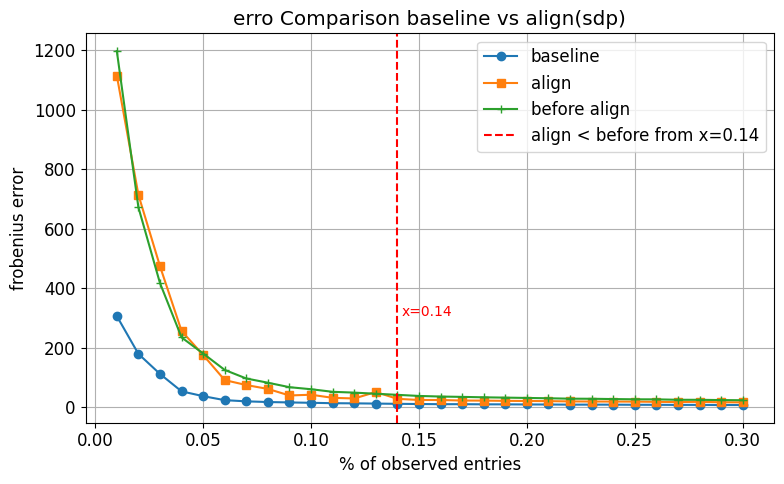

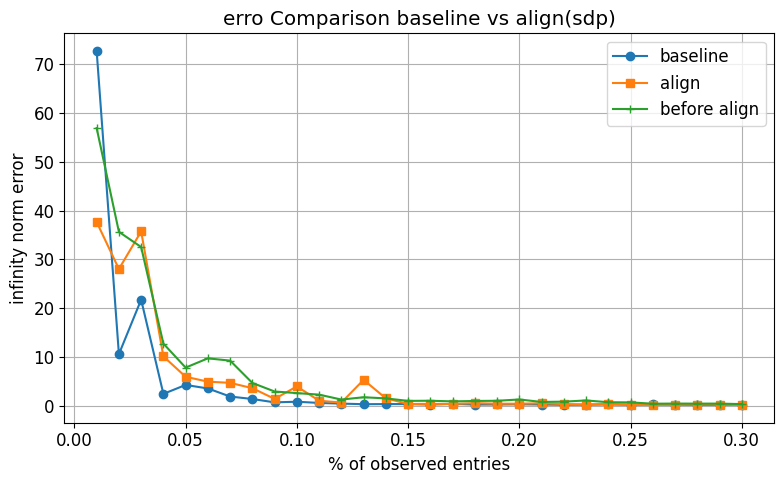

In [23]:
M_true=generate_low_rank_matrix(500,100,2,1,0.1,seed=42)
noise = np.random.normal(loc=0.0, scale=np.sqrt(0.01), size=M_true.shape)
M = M_true + noise
blocks_true=split_matrix_exactly(M_true,5)
baseline_fro_list = []
align_fro_align = []
before_fro_align=[]
baseline_inf_list = []
align_inf_align = []
before_inf_align=[]

arr = np.linspace(0.01, 0.30, 30)  
keep_ratios = arr.tolist()

for ratio in keep_ratios:

    M_masked = mask_matrix_with_noise(M, keep_ratio=ratio, sigma=0, seed=None)[0]
    block_masked=split_matrix_exactly(M_masked,5)
    


    #baseline
    recovery = debiased_MC(M_masked, p=ratio, model="sdp", rank=2)
    baseline_fro_list.append(compute_error(M_true, recovery,mode="Fro"))
    baseline_inf_list.append(compute_error(M_true, recovery,mode="inf"))

    #align
    V_list = []
    L_list = []
    fro_list=[]
    inf_list=[]
    fro_list_before=[]
    inf_list_before=[]
    

    
    for i, blk_masked in enumerate(block_masked):
        blk_completed = debiased_MC(blk_masked, p=ratio, model="sdp", rank=2)
        error_fro=compute_error(blocks_true[i], blk_completed, mode="Fro")
        error_inf=compute_error(blocks_true[i], blk_completed, mode="inf")
        fro_list_before.append(error_fro)
        inf_list_before.append(error_inf)


        
    #align
        U, S, V_blk = truncated_svd(blk_completed, r=2, tol=1e-10)
        V_list.append(V_blk.T)    


    
    before_fro_align.append(np.sum(fro_list_before))
    before_inf_align.append(np.max(inf_list_before))

    V_align = distributed_eigenspace_estimation(V_list, V_ref=None)

    for i, m in enumerate(block_masked):
        L = solve_L_with_missing(m, V_align.T)
        L_list.append(L)
        blk_rec_align = L @ V_align.T
        error_align_fro = compute_error(blocks_true[i], blk_rec_align, mode="Fro")
        error_align_inf = compute_error(blocks_true[i], blk_rec_align, mode="inf")
        fro_list.append(error_align_fro)
        inf_list.append(error_align_inf)

    align_fro_align.append(np.sum(fro_list))
    align_inf_align.append(np.max(inf_list))


df = pd.DataFrame({
    "% observed": keep_ratios,
    "baseline": baseline_fro_list,
    "before align": before_fro_align,
    "align": align_fro_align
})

from IPython.display import display
display(df.round(2))  
#ploting
plt.rcParams.update({'font.size': 12})



plt.figure(figsize=(8, 5))
plt.plot(keep_ratios, baseline_fro_list, marker='o', label='baseline')
plt.plot(keep_ratios, align_fro_align, marker='s', label='align')
plt.plot(keep_ratios, before_fro_align, marker='+', label='before align')

for i in range(len(keep_ratios)):
    if all(a < b for a, b in zip(align_fro_align[i:], before_fro_align[i:])):
        x_val = keep_ratios[i]
        plt.axvline(x=x_val, color='red', linestyle='--', label=f'align < before from x={x_val:.2f}')
        plt.text(x_val + 0.002, max(baseline_fro_list), f'x={x_val:.2f}', color='red', fontsize=10)
        break  

plt.xlabel('% of observed entries')
plt.ylabel('frobenius error')
plt.title('erro Comparison baseline vs align(sdp)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




plt.rcParams.update({'font.size': 12})


plt.figure(figsize=(8, 5))
plt.plot(keep_ratios, baseline_inf_list, marker='o', label='baseline')
plt.plot(keep_ratios, align_inf_align, marker='s', label='align')
plt.plot(keep_ratios, before_inf_align, marker='+', label='before align')
plt.xlabel('% of observed entries')
plt.ylabel('infinity norm error')
plt.title('erro Comparison baseline vs align(sdp)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**sdp  U(100,2) and V(100,2), $M=UV^t$  and $U_{ij} \sim N (1,0.1)$ ,$V_{ij} \sim N (1,0.1)$,$E_{ij} \sim N (0,0.01)$**

,% observed,baseline,before align,align
0,0.01,236.01,829.78,521.28
1,0.02,143.93,557.53,586.85
2,0.03,84.16,459.90,479.26
3,0.04,56.84,370.27,470.59
4,0.05,39.30,318.58,264.22
5,0.06,24.45,256.53,162.32
6,0.07,17.40,237.12,133.64
7,0.08,15.94,212.45,130.46
8,0.09,12.15,191.97,87.39
9,0.10,10.86,172.38,82.68


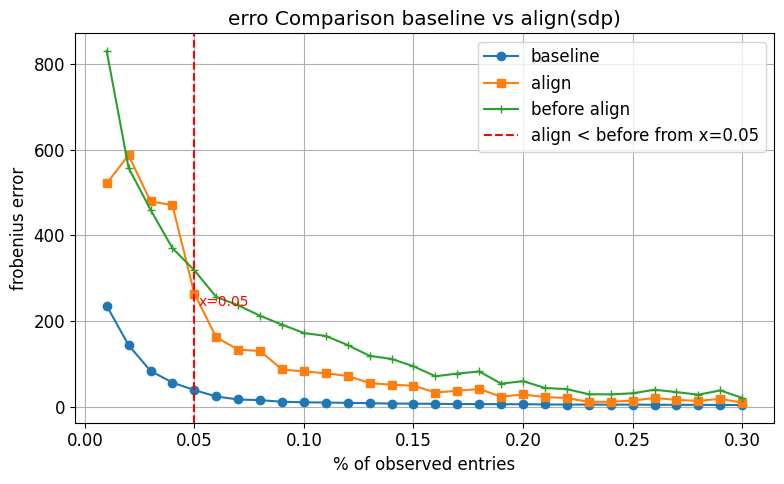

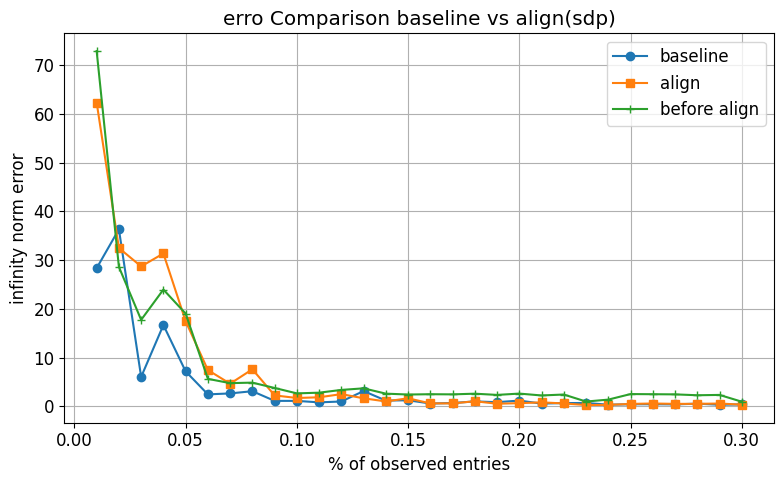

In [32]:
M_true=generate_low_rank_matrix(100,100,2,1,0.1,seed=42)
noise = np.random.normal(loc=0.0, scale=np.sqrt(0.01), size=M_true.shape)
M = M_true + noise
blocks_true=split_matrix_exactly(M_true,5)
baseline_fro_list = []
align_fro_align = []
before_fro_align=[]
baseline_inf_list = []
align_inf_align = []
before_inf_align=[]

arr = np.linspace(0.01, 0.30, 30)  
keep_ratios = arr.tolist()

for ratio in keep_ratios:

    M_masked = mask_matrix_with_noise(M, keep_ratio=ratio, sigma=0, seed=None)[0]
    block_masked=split_matrix_exactly(M_masked,5)
    


    #baseline
    recovery = debiased_MC(M_masked, p=ratio, model="sdp", rank=2)
    baseline_fro_list.append(compute_error(M_true, recovery,mode="Fro"))
    baseline_inf_list.append(compute_error(M_true, recovery,mode="inf"))

    #align
    V_list = []
    L_list = []
    fro_list=[]
    inf_list=[]
    fro_list_before=[]
    inf_list_before=[]
    

    
    for i, blk_masked in enumerate(block_masked):
        blk_completed = debiased_MC(blk_masked, p=ratio, model="sdp", rank=2)
        error_fro=compute_error(blocks_true[i], blk_completed, mode="Fro")
        error_inf=compute_error(blocks_true[i], blk_completed, mode="inf")
        fro_list_before.append(error_fro)
        inf_list_before.append(error_inf)


        
    #align
        U, S, V_blk = truncated_svd(blk_completed, r=2, tol=1e-10)
        V_list.append(V_blk.T)    


    
    before_fro_align.append(np.sum(fro_list_before))
    before_inf_align.append(np.max(inf_list_before))

    V_align = distributed_eigenspace_estimation(V_list, V_ref=None)

    for i, m in enumerate(block_masked):
        L = solve_L_with_missing(m, V_align.T)
        L_list.append(L)
        blk_rec_align = L @ V_align.T
        error_align_fro = compute_error(blocks_true[i], blk_rec_align, mode="Fro")
        error_align_inf = compute_error(blocks_true[i], blk_rec_align, mode="inf")
        fro_list.append(error_align_fro)
        inf_list.append(error_align_inf)

    align_fro_align.append(np.sum(fro_list))
    align_inf_align.append(np.max(inf_list))


df = pd.DataFrame({
    "% observed": keep_ratios,
    "baseline": baseline_fro_list,
    "before align": before_fro_align,
    "align": align_fro_align
})

from IPython.display import display
display(df.round(2))  
#ploting
plt.rcParams.update({'font.size': 12})



plt.figure(figsize=(8, 5))
plt.plot(keep_ratios, baseline_fro_list, marker='o', label='baseline')
plt.plot(keep_ratios, align_fro_align, marker='s', label='align')
plt.plot(keep_ratios, before_fro_align, marker='+', label='before align')

for i in range(len(keep_ratios)):
    if all(a < b for a, b in zip(align_fro_align[i:], before_fro_align[i:])):
        x_val = keep_ratios[i]
        plt.axvline(x=x_val, color='red', linestyle='--', label=f'align < before from x={x_val:.2f}')
        plt.text(x_val + 0.002, max(baseline_fro_list), f'x={x_val:.2f}', color='red', fontsize=10)
        break  

plt.xlabel('% of observed entries')
plt.ylabel('frobenius error')
plt.title('erro Comparison baseline vs align(sdp)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




plt.rcParams.update({'font.size': 12})


plt.figure(figsize=(8, 5))
plt.plot(keep_ratios, baseline_inf_list, marker='o', label='baseline')
plt.plot(keep_ratios, align_inf_align, marker='s', label='align')
plt.plot(keep_ratios, before_inf_align, marker='+', label='before align')
plt.xlabel('% of observed entries')
plt.ylabel('infinity norm error')
plt.title('erro Comparison baseline vs align(sdp)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**denoise exp**

In [53]:
M_true=generate_low_rank_matrix(500,100,2,1,0.1,seed=42)
noise = np.random.normal(loc=0.0, scale=np.sqrt(0.01), size=M_true.shape)
M = M_true + noise
blocks_true=split_matrix_exactly(M_true,5)
blocks = split_matrix_exactly(M,5)


recovery = denoise_method(M, rank=2)
baseline_fro=compute_error(M_true, recovery,mode="Fro")
baseline_inf=compute_error(M_true, recovery,mode="inf")

V_list = []
L_list = []
fro_list_before=[]
inf_list_before=[]
fro_list=[]
inf_list=[]



for i, blk in enumerate(blocks):
    blk_completed = denoise_method(blk,rank=2)

    error_fro=compute_error(blocks_true[i], blk_completed, mode="Fro")
    error_inf=compute_error(blocks_true[i], blk_completed, mode="inf")
    fro_list_before.append(error_fro)
    inf_list_before.append(error_inf)
    U, S, V_blk = truncated_svd(blk_completed, r=2, tol=1e-10)
    V_list.append(V_blk.T)    

    
before_fro_align=np.sum(fro_list_before)
before_inf_align=np.max(inf_list_before)

V_align = distributed_eigenspace_estimation(V_list, V_ref=None)

for i, m in enumerate(blocks):
    L = solve_L_with_missing(m, V_align.T)
    L_list.append(L)
    blk_rec_align = L @ V_align.T
    error_align_fro = compute_error(blocks_true[i], blk_rec_align, mode="Fro")
    error_align_inf = compute_error(blocks_true[i], blk_rec_align, mode="inf")
    fro_list.append(error_align_fro)
    inf_list.append(error_align_inf)

align_fro_align=np.sum(fro_list)
align_inf_align=np.max(inf_list)

df1 = pd.DataFrame({
    "Method": ["baseline", "before_align", "align"],
    "Frobenius Error": [baseline_fro, before_fro_align, align_fro_align]
})

from IPython.display import display
display(df1.round(3))  

df2 = pd.DataFrame({
    "Method": ["baseline", "before_align", "align"],
    "infinity Error": [baseline_inf, before_inf_align, align_inf_align]
})

display(df2.round(3))  

,Method,Frobenius Error
0,baseline,3.958
1,before_align,12.482
2,align,9.458


,Method,infinity Error
0,baseline,0.114
1,before_align,0.152
2,align,0.129
